In [17]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
import pickle

In [6]:

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


In [8]:
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)


In [9]:

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [10]:

weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [11]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [9]:
#training
batch_size = 64

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=100,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/100
781/781 [==============================] - 178s 228ms/step - loss: 1.8777 - acc: 0.4307 - val_loss: 1.3583 - val_acc: 0.5956
Epoch 2/100
781/781 [==============================] - 178s 228ms/step - loss: 1.2482 - acc: 0.5986 - val_loss: 1.3860 - val_acc: 0.6168
Epoch 3/100
781/781 [==============================] - 178s 227ms/step - loss: 1.0716 - acc: 0.6558 - val_loss: 1.0290 - val_acc: 0.6917
Epoch 4/100
781/781 [==============================] - 178s 228ms/step - loss: 0.9684 - acc: 0.6935 - val_loss: 0.8218 - val_acc: 0.7541
Epoch 5/100
781/781 [==============================] - 178s 228ms/step - loss: 0.9023 - acc: 0.7185 - val_loss: 0.8201 - val_acc: 0.7621
Epoch 6/100
781/781 [==============================] - 178s 227ms/step - loss: 0.8568 - acc: 0.7384 - val_loss: 0.7786 - val_acc: 0.7725
Epoch 7/100
781/781 [==============================] - 177s 227ms/step - loss: 0.8242 - acc: 0.7516 - val_loss: 0.7711 - val_acc: 0.7741
Epoch 8/100
781/781 [====================

In [13]:
#save to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model.h5')    

#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [13]:
top_layer = model.layers[0]
top_layer

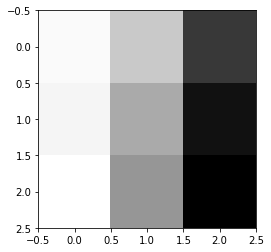

In [24]:
import matplotlib.pyplot as plt
plt.imshow(top_layer.get_weights()[0][2:, :, :, 30].squeeze(), cmap='gray')

In [27]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = json.load(open('home/dp1@it079824/Document/zoeML/Assginment2/model', 'r')
# Save it under the form of a json file
json.dump(history_dict, open('home/dp1@it079824/Document/zoeML/Assginment2/model', 'w'))

SyntaxError: invalid syntax (<ipython-input-27-18ae24210207>, line 5)

In [12]:
history = model.history

AttributeError: 'Sequential' object has no attribute 'history'

In [41]:
# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


AttributeError: 'Callback' object has no attribute 'history'

In [1]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

Using TensorFlow backend.


NameError: name 'model' is not defined

In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))


NameError: name 'model' is not defined

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils \
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot 